In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


games_df = pd.read_csv('games_data5000.csv') 

vectorizer = TfidfVectorizer(stop_words='english')

games_df['features'] = games_df['genres'] + ' ' + games_df['platforms'] + ' ' + games_df['tags']
tfidf_matrix = vectorizer.fit_transform(games_df['features'])  


def train_knn_model(tfidf_matrix, n_neighbors=10):
    knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn.fit(tfidf_matrix)
    return knn

knn_model = train_knn_model(tfidf_matrix)

with open('k_means5000.pkl', 'wb') as f:
    pickle.dump(knn_model, f)


def recommend_games_knn(game_title, knn_model, games_df, tfidf_matrix):
    idx = games_df[games_df['name'] == game_title].index[0]
    distances, indices = knn_model.kneighbors(tfidf_matrix[idx], n_neighbors=11) 


    game_indices = indices.flatten()[1:] 

    
    return games_df.iloc[game_indices]


test_games = ['Grand Theft Auto V', 'Hollow Knight']  
relevant_games = {
    'Grand Theft Auto V': ['Grand Theft Auto: Vice City', 'Grand Theft Auto IV'],
    'Hollow Knight': ['Ori and the Blind Forest', 'Cuphead']
}

# Evaluation function
def evaluate_recommendations(recommendation_function, test_game_titles, relevant_games):
    hits = 0
    total = 0

    for game_title in test_game_titles:
        recommended = recommendation_function(game_title)
        recommended_titles = recommended['name'].tolist()

        if game_title in relevant_games:
            hits += len(set(recommended_titles) & set(relevant_games[game_title]))
            total += len(relevant_games[game_title])

    return hits, total, hits / total if total > 0 else 0

# Calculate metrics for KNN model
def calculate_metrics(recommendation_function, test_game_titles, relevant_games):
    precision_list = []
    recall_list = []
    f1_list = []
    hits = 0

    for game_title in test_game_titles:
        recommended = recommendation_function(game_title)
        recommended_titles = recommended['name'].tolist()

        if game_title in relevant_games:
            relevant = relevant_games[game_title]
            true_positives = len(set(recommended_titles) & set(relevant))
            false_positives = len(set(recommended_titles) - set(relevant))
            false_negatives = len(set(relevant) - set(recommended_titles))

            # Precision, Recall, F1 Score calculations
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            if true_positives > 0:
                hits += 1  

    hit_rate = hits / len(test_game_titles) if len(test_game_titles) > 0 else 0
    return {
        'precision': np.mean(precision_list),
        'recall': np.mean(recall_list),
        'f1_score': np.mean(f1_list),
        'hit_rate': hit_rate
    }


Precision: 0.05
Recall: 0.25
F1 Score: 0.08
Hit Rate: 0.50


/var/folders/xp/190q7gn144b1r1y55thhkym00000gn/T/ipykernel_1705/48072495.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_data_knn.keys()), y=list(metrics_data_knn.values()), palette='viridis')


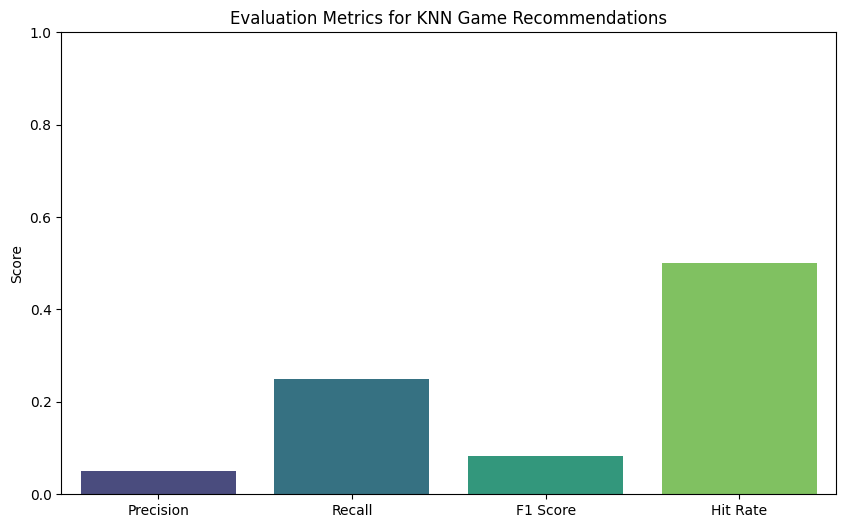

In [ ]:

metrics_knn = calculate_metrics(lambda title: recommend_games_knn(title, knn_model, games_df, tfidf_matrix), test_games, relevant_games)


print(f"Precision: {metrics_knn['precision']:.2f}")
print(f"Recall: {metrics_knn['recall']:.2f}")
print(f"F1 Score: {metrics_knn['f1_score']:.2f}")
print(f"Hit Rate: {metrics_knn['hit_rate']:.2f}")

metrics_data_knn = {
    'Precision': metrics_knn['precision'],
    'Recall': metrics_knn['recall'],
    'F1 Score': metrics_knn['f1_score'],
    'Hit Rate': metrics_knn['hit_rate']
}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics_data_knn.keys()), y=list(metrics_data_knn.values()), palette='viridis')
plt.title('Evaluation Metrics for KNN Game Recommendations')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

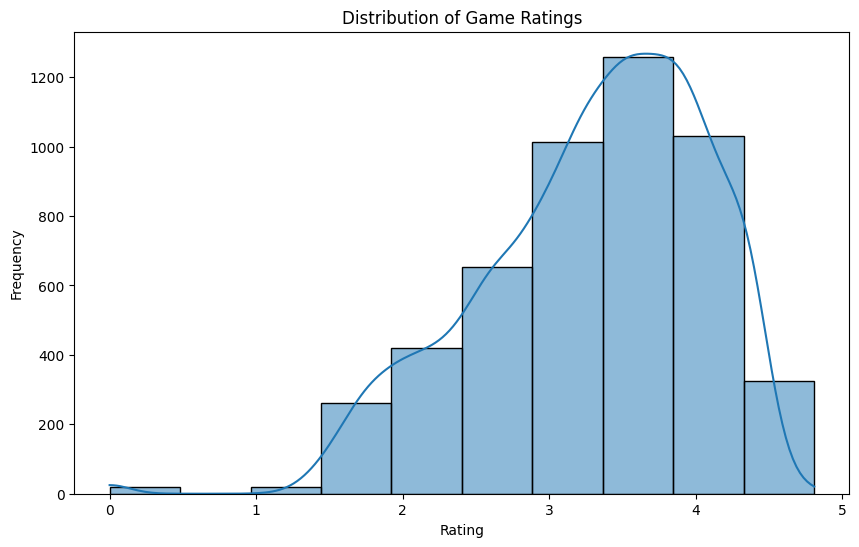

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



# 1. Distribution of Game Ratings
def plot_game_ratings_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['rating'], bins=10, kde=True)
    plt.title('Distribution of Game Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

# 2. Count of Games by Genre
def plot_games_by_genre(df):
    plt.figure(figsize=(10, 6))
    top_genres = df['genres'].explode().value_counts().head(10)

    sns.barplot(x=top_genres.values, y=top_genres)
    plt.title('Top 10 Genres by Game Count')
    plt.xlabel('Count of Games')
    plt.ylabel('Genre')
    plt.show()

# 3. Number of Games Released per Year
def plot_games_released_per_year(df):
    df['released_year'] = pd.to_datetime(df['released']).dt.year
    games_per_year = df['released_year'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(x=games_per_year.index, y=games_per_year.values)
    plt.title('Number of Games Released per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Games')
    plt.show()

# 4. Distribution of Playtime
def plot_playtime_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['playtime'], bins=20, kde=True)
    plt.title('Distribution of Playtime (hours)')
    plt.xlabel('Playtime (hours)')
    plt.ylabel('Frequency')
    plt.show()

# 5. Count of Games by Platform
def plot_games_by_platform(df):
    plt.figure(figsize=(10, 6))
    top_platforms = df['platforms'].explode().value_counts().head(10)
    sns.barplot(x=top_platforms.values, y=top_platforms.index)
    plt.title('Top 10 Platforms by Game Count')
    plt.xlabel('Count of Games')
    plt.ylabel('Platform')
    plt.show()

# 6. Visualization of Evaluation Metrics
def plot_evaluation_metrics(metrics):
    plt.figure(figsize=(10, 6))
    metric_names = ['Precision', 'Recall', 'F1 Score', 'Hit Rate']
    values = [metrics['precision'], metrics['recall'], metrics['f1_score'], metrics['hit_rate']]

    sns.barplot(x=metric_names, y=values)
    plt.title('Evaluation Metrics for Game Recommendation System')
    plt.ylabel('Score')
    plt.show()

# Example of how to call these functions
df = pd.read_csv("/Users/vijaykrishnasundarans/Documents/streamlit-GameRS (Final)/data/games_data5000.csv")
# Assuming df is your DataFrame with game data
plot_game_ratings_distribution(df)

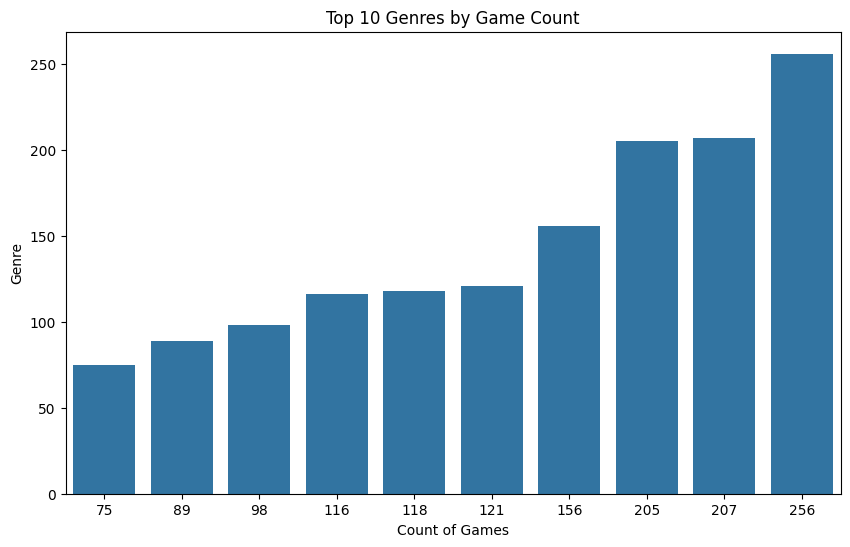

In [ ]:
plot_games_by_genre(df)

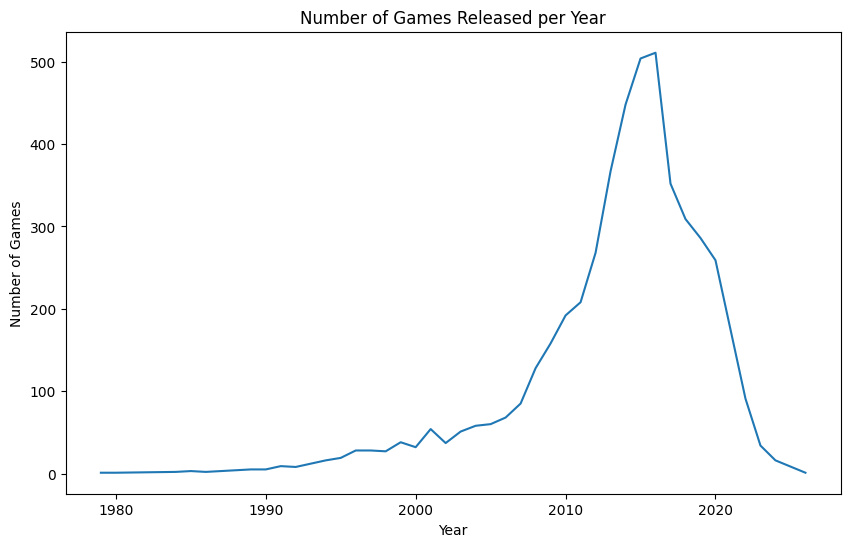

In [ ]:
plot_games_released_per_year(df)

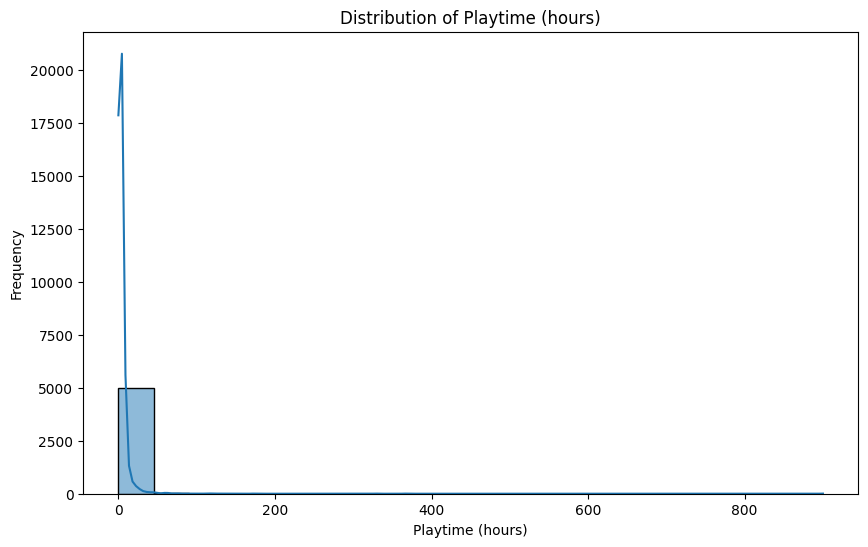

In [ ]:
plot_playtime_distribution(df)


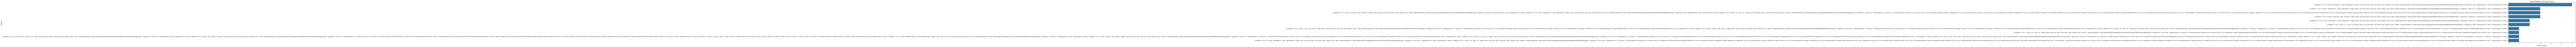

In [ ]:
plot_games_by_platform(df)

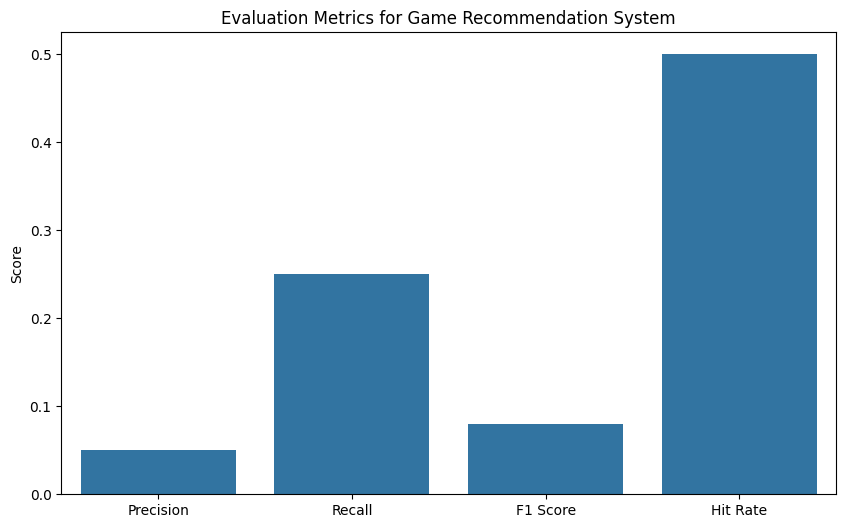

In [ ]:

metrics = {'precision': 0.05, 'recall': 0.25, 'f1_score': 0.08, 'hit_rate': 0.50}
plot_evaluation_metrics(metrics)